<a href="https://colab.research.google.com/github/hernss/MachineLearningCourse/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

Natural Language processing

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-846c57fc-5606-7b5c-3c8b-7d8b7195bba1)


## Get helper functions


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-02-28 22:22:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-28 22:22:15 (78.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're goingo to be using is kaggle's introductions to NLP dataset (text examples of Tweets labelled as disaster ot not)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

--2023-02-28 22:22:23--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-02-28 22:22:23 (99.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Become one with the data

In [4]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df = train_df.sample(frac=1, random_state=42) # Shuffle data
train_df.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Let's visualize some random training example

import random

random_index = random.randint(0, len(train_df)-5)
for row in train_df[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}")
  print("---\n")

Target: 1 (real disaster)
Text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/81HVV3N3rS
---

Target: 1 (real disaster)
Text:
A gas thing just exploded and I heard screams and now the whole street smells of gas ... ??
---

Target: 0 (not real disaster)
Text:
OH. #TeamHennessy #NJ Obliteration  @tprimo24 ROUND 1 Happy Birthday @djeddygnj Colombian FestivalÛ_ https://t.co/mRv54fiDfn
---

Target: 0 (not real disaster)
Text:
Apollo Brown - Detonate (feat. M.O.P.) by Mello Music Group via #soundcloud https://t.co/PRojeAvG8T
---

Target: 0 (not real disaster)
Text:
Can you recommend anyone for this #job? RN Emergency Services Full Time 3p - 3\:30a Rose de Lima Campus - http://t.co/xQrLEWiA4x #Hiring
---



# Split training and validation datasets

In [9]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["text"].to_numpy(), 
                                                                            train_df["target"].to_numpy(), 
                                                                            test_size=0.1,
                                                                            random_state=42)

In [10]:
len(train_sentences), len(train_labels)

(6851, 6851)

In [11]:
len(val_sentences), len(val_labels)

(762, 762)

# Converting text into numbers
* Tokenization
* Embedding

In [12]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the deafult vectorization paremeters

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

In [13]:
# Find average number of tokens
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [14]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [15]:
text_vectorizer.adapt(train_sentences)

In [16]:
# Create a sample sentence and trokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [17]:
# Choose a random sentence fro the training dataset
random_sentence = random.choice(train_sentences)
print(f"Original Text: {random_sentence}\n\n")
print(f"Vectorized Text: {text_vectorizer([random_sentence])}")

Original Text: China's Stock Market Crash: Are There Gems In The Rubble?: ChinaÛªs stock market crash this su... http://t.co/KABK3tcJNL ...  via @Forbes


Vectorized Text: [[1034  413  457   85   22   74  948    4    2  643 1882  413  457   85
    19]]


In [18]:
# Get unique word in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5 = words_in_vocab[:5]
bottom_5 = words_in_vocab[-5:]
print(f"Number of word: {len(words_in_vocab)}")
print(f"Most common words: {top_5 }")
print(f"Least common words: {bottom_5}")

Number of word: 10000
Most common words: ['', '[UNK]', 'the', 'a', 'in']
Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# Creating an Embedding Layer

* 'input_dim' the size of our vocabulary
* 'output_dim the size fo the output embedding vector
* 'input_length'

In [19]:
# TensorFlow embeding layer

from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                            output_dim=128,
                            input_length=max_length)
embedding

In [20]:
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n {random_sentence}\n")
print(f"Embedded Version:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Text:
 I added a video to a @YouTube playlist http://t.co/v2yXurne2p Natural Disaster Survival - HUG BY A GUEST!! on Roblox

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 7.54320621e-03, -3.36085111e-02, -2.57939100e-03, ...,
         -1.06361881e-02,  3.83190773e-02, -1.90679673e-02],
        [-4.34720293e-02, -3.45998295e-02, -3.90329733e-02, ...,
         -3.81046422e-02, -6.22322410e-03, -4.09740582e-02],
        [ 4.75198738e-02,  4.24592569e-03, -1.03655681e-02, ...,
         -1.02602616e-02,  2.39403173e-03, -5.14104217e-03],
        ...,
        [-3.10422108e-03,  8.41131061e-03, -4.11138684e-03, ...,
         -3.06016337e-02, -3.78681794e-02, -1.47179365e-02],
        [-3.15097459e-02, -2.73922216e-02, -2.99316775e-02, ...,
         -2.87774093e-02,  8.46758485e-05, -2.28559021e-02],
        [ 4.75198738e-02,  4.24592569e-03, -1.03655681e-02, ...,
         -1.02602616e-02,  2.39403173e-03, -5.14104217e-03]]],
      dtype=float32)>

In [21]:
# Checout a single token embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00754321, -0.03360851, -0.00257939, -0.04637852,  0.02776334,
        -0.04210054, -0.03299441,  0.02103552,  0.03244473, -0.006141  ,
         0.00516455, -0.02132195,  0.03071869, -0.04029044,  0.04932557,
         0.04335544,  0.04247412,  0.01770047,  0.00551011, -0.0358083 ,
         0.02265022, -0.0182094 ,  0.00136769, -0.04142923, -0.04946012,
         0.00190158,  0.01283703, -0.04469222,  0.01256219,  0.0093784 ,
         0.01763246,  0.04641071, -0.00552677, -0.02598575,  0.04178527,
        -0.03504483,  0.03670197, -0.04005512,  0.0306851 ,  0.04891844,
        -0.0311338 , -0.00995783,  0.04186637, -0.01971745,  0.03433392,
        -0.02896633,  0.02820769, -0.01380595, -0.01273874, -0.00920276,
        -0.01708645, -0.03330411,  0.04558433, -0.01270815,  0.00224423,
        -0.01548951,  0.0020627 ,  0.0432334 ,  0.01205681,  0.01325954,
        -0.04759508,  0.02121928, -0.02448732, -0.00576979,  0.00656347,
  

# Modeling a text dataset

* Model 0: Naive Bayes (Baseline)
* Model 1: Feed-forward neural network (Dense model)
* Model 2: LSTM Model
* Model 3: GRU Model
* Model 4: Bidirectional_LSTM Model (RNN)
* Model 5: 1D Convolutional Neural network
* Model 6: Tensorflow Hub pretrained feature extraction model
* Model 7: Same as model 6 with 10% of data

## Model 0: Baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert word to numbers using tdidf
    ("clf", MultinomialNB())      # model the text
])

# Fit the pipeline

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate our model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our basemodel accuracy: {baseline_score*100:.2f}")

Our basemodel accuracy: 79.27


In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function 

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy precision recall and F1_score of a binary classification model
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and F1_score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy" : model_accuracy,
                  "precision": model_precision,
                  "recall" : model_recall,
                  "f1" : model_f1}
  return model_results          

In [26]:
baseline_results = calculate_results(val_labels,baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: Feed-forward neural network

In [27]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [28]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)    # String input
x = text_vectorizer(inputs)                           # Turn input text in numbers
x = embedding(x)                                      # Create an embedding for tokens
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [29]:
# Compile and fit the model

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230228-222232
Epoch 1/5
215/215 [==============================] - 21s 61ms/step - loss: 0.6103 - accuracy: 0.6939 - val_loss: 0.5364 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4409 - accuracy: 0.8170 - val_loss: 0.4700 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3467 - accuracy: 0.8603 - val_loss: 0.4587 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2835 - accuracy: 0.8899 - val_loss: 0.4623 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2369 - accuracy: 0.9139 - val_loss: 0.4785 - val_accuracy: 0.7835


In [30]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape


24/24 [==============================] - 0s 2ms/step


(762, 1)

In [31]:
model_1_pred_probs[:10]

array([[0.38089627],
       [0.8278981 ],
       [0.9976133 ],
       [0.13099042],
       [0.12279742],
       [0.93904716],
       [0.90404993],
       [0.9922651 ],
       [0.9694457 ],
       [0.3073923 ]], dtype=float32)

In [32]:
# Convert model predictions probability to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [33]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.7834645669291339,
 'precision': 0.7868445599717488,
 'recall': 0.7834645669291339,
 'f1': 0.7809185675137833}

In [34]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Visualizing learned embeddings

In [35]:
# Get the vocabulary from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10], max_vocab_length

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'], 10000)

In [36]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [37]:
# Get the weight matriz of embedding layer
embed_weight = model_1.get_layer("embedding").get_weights()
embed_weight

[array([[ 0.03271357,  0.00881404, -0.03467558, ...,  0.0134818 ,
         -0.06290805,  0.0369674 ],
        [-0.0249108 ,  0.03191932,  0.03695968, ..., -0.02090443,
         -0.02400827, -0.02610337],
        [-0.00907359,  0.03650263, -0.04705024, ...,  0.0131975 ,
          0.03523729,  0.03364068],
        ...,
        [ 0.03235091, -0.00192301,  0.03166186, ...,  0.04350618,
          0.00725449,  0.03921603],
        [ 0.00098458,  0.01389158,  0.00726732, ...,  0.03110291,
         -0.07169478,  0.00365287],
        [-0.08105271,  0.03778543, -0.07449736, ...,  0.08058732,
         -0.02720411,  0.0976953 ]], dtype=float32)]

In [38]:
embed_weight[0].shape

(10000, 128)

In [39]:
import io

# Create embeding files
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weight[0][index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [40]:
# Download file from Colab
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 2: LSTM Recurrent Neural Network

LSTM = Long short term memory


In [41]:
# Create a LSTM model

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(units=64, return_sequences=True)(x) # When you are stacking RNNs cells together, you need to set return_sequence=True
x = layers.LSTM(64)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________

In [42]:
# Compile and fit the model 

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(x=train_sentences, y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20230228-222317
Epoch 1/5
215/215 [==============================] - 13s 40ms/step - loss: 0.2230 - accuracy: 0.9210 - val_loss: 0.5542 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1552 - accuracy: 0.9428 - val_loss: 0.6352 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1269 - accuracy: 0.9536 - val_loss: 0.7103 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1053 - accuracy: 0.9591 - val_loss: 0.7643 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0844 - accuracy: 0.9673 - val_loss: 0.9222 - val_accuracy: 0.7769


In [43]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[7.1542054e-01],
       [9.0110636e-01],
       [9.9973923e-01],
       [7.1575195e-02],
       [5.6384108e-04],
       [9.9906319e-01],
       [8.7285000e-01],
       [9.9982858e-01],
       [9.9972385e-01],
       [5.6162864e-01]], dtype=float32)

In [44]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [45]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.7769028871391076,
 'precision': 0.7765743067490619,
 'recall': 0.7769028871391076,
 'f1': 0.7763928797999775}

## Model 3: GRU (Gated recurrent unit)

In [46]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64, return_sequences=True)(x) # return_sequence=True for stackin RNNs layers
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [47]:
# Compile and fit the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(x=train_sentences, y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_gru")])

Saving TensorBoard log files to: model_logs/model_3_gru/20230228-222340
Epoch 1/5
215/215 [==============================] - 14s 52ms/step - loss: 0.1526 - accuracy: 0.9425 - val_loss: 0.8297 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0831 - accuracy: 0.9691 - val_loss: 0.9588 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0691 - accuracy: 0.9729 - val_loss: 1.2369 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0555 - accuracy: 0.9768 - val_loss: 1.1085 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0503 - accuracy: 0.9764 - val_loss: 1.2575 - val_accuracy: 0.7638


In [48]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[7.5648364e-04],
       [8.6411625e-01],
       [9.9988067e-01],
       [1.2611769e-01],
       [6.9199465e-05],
       [9.9948919e-01],
       [8.0489528e-01],
       [9.9992144e-01],
       [9.9990761e-01],
       [8.2027084e-01]], dtype=float32)

In [49]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [50]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 0.7637795275590551,
 'precision': 0.766310461192351,
 'recall': 0.7637795275590551,
 'f1': 0.7610762606610089}

## Model 4: Biderectional-LSTM


In [51]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [52]:
# Copmpile and fit the model

model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(x=train_sentences, y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230228-222404
Epoch 1/5
215/215 [==============================] - 14s 42ms/step - loss: 0.1121 - accuracy: 0.9686 - val_loss: 0.9854 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0524 - accuracy: 0.9791 - val_loss: 1.0704 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0455 - accuracy: 0.9785 - val_loss: 1.4252 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0412 - accuracy: 0.9788 - val_loss: 1.3244 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0438 - accuracy: 0.9796 - val_loss: 1.2678 - val_accuracy: 0.7664


In [53]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[2.6776401e-02],
       [9.7806805e-01],
       [9.9997950e-01],
       [1.8058065e-01],
       [6.9265021e-05],
       [9.9973160e-01],
       [9.8744440e-01],
       [9.9998868e-01],
       [9.9997604e-01],
       [9.9719018e-01]], dtype=float32)

In [54]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.7664041994750657,
 'precision': 0.7660932193902303,
 'recall': 0.7664041994750657,
 'f1': 0.7661637676118346}

## Model 5: Convolutional neural network for Text

In [56]:
from tensorflow.keras import layers

embedding_text = embedding(text_vectorizer(["this is a test sentence"]))  # Turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")

conv_1d_output = conv_1d(embedding_text)  # Pass test embedding through conv1D layer
max_pool = layers.GlobalMaxPooling1D()

max_pool_output = max_pool(conv_1d_output)

embedding_text.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [57]:
embedding_text

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-4.04257514e-02,  2.77776308e-02, -5.41543402e-02, ...,
          1.51064415e-02,  1.29883215e-02, -1.48731852e-02],
        [ 1.97878256e-02,  3.36982384e-02,  1.60100544e-03, ...,
          5.41789224e-03,  5.79228811e-02,  4.73282561e-02],
        [ 3.19370739e-02,  7.50184990e-05, -1.96106452e-02, ...,
          1.20170144e-02, -1.12613570e-02, -1.29157566e-02],
        ...,
        [ 1.17921149e-02,  8.67980067e-03, -2.58861408e-02, ...,
          1.04940888e-02, -4.13924195e-02,  1.96034480e-02],
        [ 1.17921149e-02,  8.67980067e-03, -2.58861408e-02, ...,
          1.04940888e-02, -4.13924195e-02,  1.96034480e-02],
        [ 1.17921149e-02,  8.67980067e-03, -2.58861408e-02, ...,
          1.04940888e-02, -4.13924195e-02,  1.96034480e-02]]],
      dtype=float32)>

In [58]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.00303629, 0.        , 0.0377146 , 0.00980714,
         0.06261379, 0.        , 0.        , 0.02792886, 0.04927392,
         0.04479613, 0.08742122, 0.        , 0.        , 0.03620797,
         0.        , 0.0553614 , 0.02483499, 0.04282794, 0.02228727,
         0.01942806, 0.        , 0.        , 0.03968208, 0.        ,
         0.        , 0.04007933, 0.00161526, 0.        , 0.03777113,
         0.06240205, 0.05008267],
        [0.        , 0.        , 0.        , 0.04386178, 0.01240869,
         0.02138118, 0.03661211, 0.        , 0.00519467, 0.        ,
         0.        , 0.02977576, 0.03172309, 0.        , 0.        ,
         0.        , 0.01918216, 0.02960403, 0.        , 0.        ,
         0.05417088, 0.04264794, 0.0044741 , 0.00111945, 0.        ,
         0.        , 0.00308561, 0.        , 0.        , 0.01183574,
         0.        , 0.        ],
        [0.        , 0.06929046, 0.01517883, 0.0039

In [59]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.        , 0.06929046, 0.02572572, 0.04386178, 0.01240869,
        0.06261379, 0.05535891, 0.011714  , 0.06395166, 0.05277961,
        0.05620767, 0.08742122, 0.03172309, 0.04214989, 0.03620797,
        0.02256432, 0.08521359, 0.04742919, 0.05871703, 0.03285024,
        0.09489742, 0.05109167, 0.01069004, 0.03968208, 0.        ,
        0.067197  , 0.04007933, 0.01514802, 0.06697021, 0.05631438,
        0.06240205, 0.05008267]], dtype=float32)>

In [60]:
# Create CNN model

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [61]:
history_5 = model_5.fit(x=train_sentences, y=train_labels, epochs=5, validation_data=(val_sentences, val_labels), callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230228-222432
Epoch 1/5
215/215 [==============================] - 11s 40ms/step - loss: 0.1201 - accuracy: 0.9648 - val_loss: 0.9567 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0752 - accuracy: 0.9724 - val_loss: 1.0334 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0616 - accuracy: 0.9761 - val_loss: 1.1595 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0556 - accuracy: 0.9777 - val_loss: 1.2060 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0514 - accuracy: 0.9791 - val_loss: 1.3252 - val_accuracy: 0.7559


In [62]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[1.0155250e-01],
       [2.7592739e-01],
       [9.9970466e-01],
       [2.3936378e-02],
       [3.2329620e-08],
       [9.9031770e-01],
       [9.2844701e-01],
       [9.9984252e-01],
       [9.9999666e-01],
       [8.9601010e-01]], dtype=float32)

In [63]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.7559055118110236,
 'precision': 0.7614718450048816,
 'recall': 0.7559055118110236,
 'f1': 0.751586917019988}

## Model 6: TensorFlow Hub pretrained model

In [65]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, 
                       "When you can the universal sentences encoder on a sentence, it turns into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [66]:
sample_sentence

"There's a flood in my street!"

In [67]:
# Create a keras layer user the USE pretrained layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE_layer")

In [68]:
# Create model using sequential api
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [69]:
history_6 = model_6.fit(x=train_sentences, y=train_labels, epochs=5, validation_data=(val_sentences, val_labels), callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230228-222524
Epoch 1/5
215/215 [==============================] - 8s 14ms/step - loss: 0.5003 - accuracy: 0.7812 - val_loss: 0.4514 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4150 - accuracy: 0.8145 - val_loss: 0.4407 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4017 - accuracy: 0.8210 - val_loss: 0.4358 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3940 - accuracy: 0.8224 - val_loss: 0.4299 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3880 - accuracy: 0.8279 - val_loss: 0.4245 - val_accuracy: 0.8176


In [70]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 18ms/step


array([[0.20187047],
       [0.78230554],
       [0.9861368 ],
       [0.2329851 ],
       [0.7320629 ],
       [0.7295985 ],
       [0.98251075],
       [0.97981983],
       [0.9453598 ],
       [0.11169291]], dtype=float32)

In [71]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [72]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8175853018372703,
 'precision': 0.8179238046805183,
 'recall': 0.8175853018372703,
 'f1': 0.8168602489629228}

In [73]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}


## Model 7: TensorFlow Hub Pretrained Feature Extractor with 10% of data

In [74]:
train_10_percent = train_df[["text", "target"]].sample(frac=0.1, random_state=42)

In [75]:
train_sentences_10 = train_10_percent["text"]
train_labels_10 = train_10_percent["target"]

len(train_sentences_10)

761

In [76]:
train_sentences_10, train_labels_10

(4955    DFR EP016 Monthly Meltdown - On Dnbheaven 2015...
 584     FedEx no longer to transport bioterror germs i...
 7411    Gunmen kill four in El Salvador bus attack: Su...
 5950    @camilacabello97 Internally and externally scr...
 5541    Radiation emergency #preparedness starts with ...
                               ...                        
 7593    I just heard a really loud bang and everyone i...
 2638              That's the ultimate road to destruction
 859     @SetZorah dad why dont you claim me that mean ...
 578     FedEx will no longer transport bioterror patho...
 7445    Crack in the path where I wiped out this morni...
 Name: text, Length: 761, dtype: object, 4955    0
 584     0
 7411    1
 5950    1
 5541    1
        ..
 7593    0
 2638    0
 859     0
 578     0
 7445    0
 Name: target, Length: 761, dtype: int64)

In [77]:
train_labels_10.value_counts()

0    413
1    348
Name: target, dtype: int64

In [78]:
# Create model 7 coping model_6 layers
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [79]:
# Fit the model
history_7 = model_7.fit(train_sentences_10, train_labels_10, epochs=5, validation_data=(val_sentences, val_labels), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_10_percent/20230228-222557
Epoch 1/5
24/24 [==============================] - 7s 86ms/step - loss: 0.6653 - accuracy: 0.7122 - val_loss: 0.6258 - val_accuracy: 0.8123
Epoch 2/5
24/24 [==============================] - 2s 97ms/step - loss: 0.5925 - accuracy: 0.8055 - val_loss: 0.5475 - val_accuracy: 0.8097
Epoch 3/5
24/24 [==============================] - 1s 36ms/step - loss: 0.5175 - accuracy: 0.8081 - val_loss: 0.4822 - val_accuracy: 0.8123
Epoch 4/5
24/24 [==============================] - 1s 48ms/step - loss: 0.4652 - accuracy: 0.8121 - val_loss: 0.4374 - val_accuracy: 0.8189
Epoch 5/5
24/24 [==============================] - 1s 36ms/step - loss: 0.4285 - accuracy: 0.8200 - val_loss: 0.4076 - val_accuracy: 0.8255


In [80]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 20ms/step


array([[0.2593037 ],
       [0.80458313],
       [0.89977425],
       [0.31825098],
       [0.8081005 ],
       [0.8182006 ],
       [0.8916026 ],
       [0.9274584 ],
       [0.8530511 ],
       [0.06013794]], dtype=float32)

In [81]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [82]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.8254593175853019,
 'precision': 0.8253671324537466,
 'recall': 0.8254593175853019,
 'f1': 0.8250899164200803}

## Making a better data split

In [83]:
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10 = train_sentences[:train_10_percent_split]
train_labels_10 = train_labels[:train_10_percent_split]

In [84]:
len(train_sentences_10), len(train_labels_10)

(685, 685)

In [85]:
# Check labels count
pd.Series(train_labels_10).value_counts()

0    406
1    279
dtype: int64

In [86]:
# Refit the model
history_7 = model_7.fit(train_sentences_10, train_labels_10, epochs=5, validation_data=(val_sentences, val_labels), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_10_percent_correct_split/20230228-222610
Epoch 1/5
22/22 [==============================] - 3s 30ms/step - loss: 0.4666 - accuracy: 0.7842 - val_loss: 0.3994 - val_accuracy: 0.8438
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4342 - accuracy: 0.8034 - val_loss: 0.4013 - val_accuracy: 0.8373
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4062 - accuracy: 0.8169 - val_loss: 0.4045 - val_accuracy: 0.8373
Epoch 4/5
22/22 [==============================] - 1s 30ms/step - loss: 0.3841 - accuracy: 0.8317 - val_loss: 0.4075 - val_accuracy: 0.8333
Epoch 5/5
22/22 [==============================] - 1s 29ms/step - loss: 0.3644 - accuracy: 0.8410 - val_loss: 0.4170 - val_accuracy: 0.8215


# Comparing the performance of each of our models

In [87]:
all_models_results = pd.DataFrame({"0_baseline": baseline_results, "1_simple_dense": model_1_results,
                                   "2_lstm": model_2_results, "3_gru": model_3_results,
                                   "4_biderectional": model_4_results, "5_conv1d": model_5_results,
                                   "6_tf_hub_use_encoder": model_6_results, "7_tf_hub_use_encoder_10_percent": model_7_results})

all_models_results = all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.786845,0.783465,0.780919
2_lstm,0.776903,0.776574,0.776903,0.776393
3_gru,0.763780,0.766310,0.763780,0.761076
4_biderectional,0.766404,0.766093,0.766404,0.766164
5_conv1d,0.755906,0.761472,0.755906,0.751587
6_tf_hub_use_encoder,0.817585,0.817924,0.817585,0.816860
7_tf_hub_use_encoder_10_percent,0.825459,0.825367,0.825459,0.825090


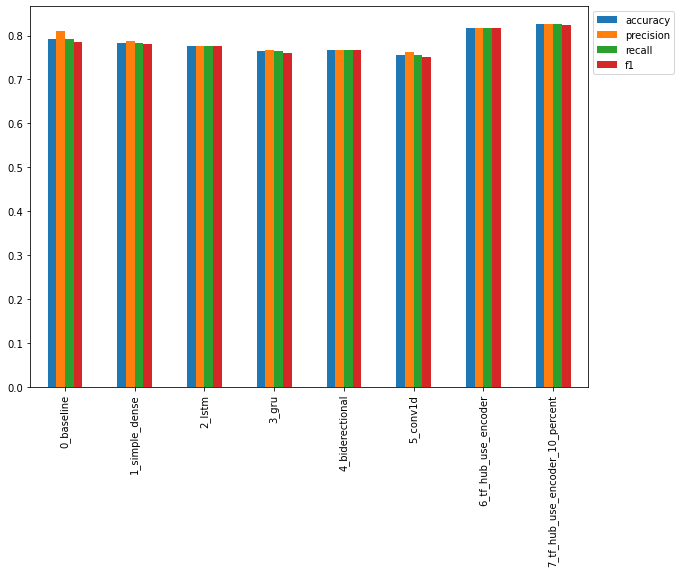

In [88]:
# Plot and compare all of model results
all_models_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

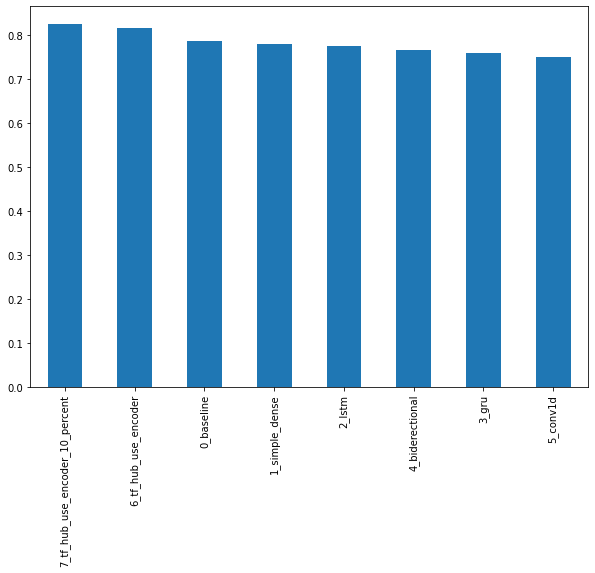

In [89]:
all_models_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

# Upload model training logs to TensorBoard.dev

In [ ]:
# Upload experiment to tensorboard
!tensorboard dev upload --logdir ./model_logs/ \
--name "NLP modelling Experiment" \
--description "Comparing different types of model architecture" \
--one_shot

In [92]:
# Listing all experiments
!tensorboard dev list

2023-02-28 22:31:38.294460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-28 22:31:38.294569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-28 22:31:38.294588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/VMC66nE5QjibuYgjd37aaw/
	Name                 NLP modelling Experiment
	Description          Comparing different types of model arch

In [ ]:
# Delete experiment
#!tensorboard dev delete --experiment_id VMC66nE5QjibuYgjd37aaw

# Saving and loading trained model

## Save model to HDF5 format

In [94]:

model_6.save("model_6.h5")

In [95]:
import tensorflow as tf
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [96]:
loaded_model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [99]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 16ms/step - loss: 0.4245 - accuracy: 0.8176


[0.4245380461215973, 0.817585289478302]

## 'SavedModel' Format


In [100]:
model_6.save("model_6_SavedModel_format")

In [101]:
loaded_model_6_savedmodel = tf.keras.models.load_model("model_6_SavedModel_format")

loaded_model_6_savedmodel.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [102]:
loaded_model_6_savedmodel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4245 - accuracy: 0.8176


[0.4245380759239197, 0.817585289478302]

# Finding the mos wrong example

In [104]:
# Download a pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
unzip_data("08_model_6_USE_feature_extractor.zip")

--2023-02-28 22:48:29--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   126MB/s    in 11s     

2023-02-28 22:48:40 (85.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [105]:
# Import previously trained model
model_6_pretrained = tf.keras.models.load_model("/content/08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [109]:
# Make predictions with the loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 0s 13ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [111]:
# Create DataFrame with validation sentences
val_df = pd.DataFrame({"text": val_sentences, "target": val_labels, "pred": model_6_pretrained_preds, "pred_probs": tf.squeeze(model_6_pretrained_pred_probs)})

val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [113]:
# Find the wrong predictions and sort by prediction probability
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)
most_wrong.head() # These are false positives

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [114]:
most_wrong.tail() # These are false negatives

,text,target,pred,pred_probs
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [116]:
# Check the false positive (model predict 1 when should been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob:{pred_prob}")
  print(f"Text: {text}")
  print("------")

Target: 0, Pred: 1.0, Prob:0.9101957678794861
Text: ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
------
Target: 0, Pred: 1.0, Prob:0.8769821524620056
Text: FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
------
Target: 0, Pred: 1.0, Prob:0.8523001074790955
Text: @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
------
Target: 0, Pred: 1.0, Prob:0.8354544043540955
Text: Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
------
Target: 0, Pred: 1.0, Prob:0.8272132873535156
Text: @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.
------
Target: 0, Pred: 1.0, Prob:0.814815878868103
Text: @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!
------
Targ

In [117]:
# Check the false negatives (model predict 1 when should been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob:{pred_prob}")
  print(f"Text: {text}")
  print("------")

Target: 1, Pred: 0.0, Prob:0.06730346381664276
Text: @DavidVonderhaar At least you were sincere ??
------
Target: 1, Pred: 0.0, Prob:0.05507583171129227
Text: @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
------
Target: 1, Pred: 0.0, Prob:0.05460337549448013
Text: Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
------
Target: 1, Pred: 0.0, Prob:0.054597001522779465
Text: going to redo my nails and watch behind the scenes of desolation of smaug ayyy
------
Target: 1, Pred: 0.0, Prob:0.049637261778116226
Text: You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
------
Target: 1, Pred: 0.0, Prob:0.043918490409851074
Text: @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
------
Target: 1, Pred: 0.0, Prob:0.042086

In [118]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


# Making predictions on test dataset

In [121]:
test_sentences = test_df["text"].to_list()
test_sentences[:10]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking...It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!']

In [125]:
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
  pred_prob = model_6_pretrained.predict([test_sample]);
  pred_prob = tf.squeeze(pred_prob)
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}")

1/1 [==============================] - 0s 41ms/step
Pred: 1, Prob: 0.987575352191925
Text:
AFP: #PKK said it carried out suicide bombing against troops in eastern #Turkey as a reprisal for 'bombing of a civilian village'
1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.051395267248153687
Text:
@Hazard_VN @AccuracyEsports add me
1/1 [==============================] - 0s 41ms/step
Pred: 0, Prob: 0.40613922476768494
Text:
Pray for our Nation &amp; her troops that defend in her. May he continue his watch over those watch over us our first responders.
1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.10475736111402512
Text:
@cameron13131313 @OtooleDalton @averywelch23 @otoole1055 first of all you can't 'hit stick' shit.. Second I'm body bagging you on sight ??????
1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.9667940735816956
Text:
TimesNewsdesk : Police link beach massacre to Tunisia museum attack
Û_ http://t.co/g11Rd44rgW) htt

# The speed/score tradeoff

In [126]:
# Let's make a function to measure the time of a prediction
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_prediction = total_time/len(samples)
  return total_time, time_per_prediction

In [127]:
pred_timer(model_6_pretrained, val_sentences)

24/24 [==============================] - 0s 18ms/step


(0.5527241780000622, 0.0007253598136483756)

In [128]:
# Calculate base model times per pred
pred_timer(model_0, val_sentences)

(0.05902998600004139, 7.746717322840078e-05)